<a href="https://colab.research.google.com/github/Deebamajeed/BRCA-Subtype-DR/blob/main/%20BRCA-Subtype-DR/DrugResponse/Code/Multiop_regression__classification_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/multiomics/Master-BRCA-ST-DR.zip

Archive:  /content/gdrive/MyDrive/multiomics/Master-BRCA-ST-DR.zip
   creating: Master-BRCA-ST-DR/Codes/
   creating: Master-BRCA-ST-DR/Codes/Drug Response/
   creating: Master-BRCA-ST-DR/Codes/Subtype-Classify/
  inflating: Master-BRCA-ST-DR/Codes/Subtype-Classify/brca_Subtype_multi-omics_ncafs.py  
  inflating: Master-BRCA-ST-DR/Codes/Subtype-Classify/graphs.ipynb  
  inflating: Master-BRCA-ST-DR/Codes/Subtype-Classify/multi-omics_rename.py  
  inflating: Master-BRCA-ST-DR/Codes/Subtype-Classify/r_other_meths.ipynb  
  inflating: Master-BRCA-ST-DR/Codes/Subtype-Classify/single_omics_meths.py  
  inflating: Master-BRCA-ST-DR/Codes/Subtype-Classify/single_omics_protiens.py  
   creating: Master-BRCA-ST-DR/Data/
   creating: Master-BRCA-ST-DR/Data/Drug Response/
   creating: Master-BRCA-ST-DR/Data/Subtype-Classify/
  inflating: Master-BRCA-ST-DR/Data/Subtype-Classify/clins.csv  
  inflating: Master-BRCA-ST-DR/Data/Subtype-Classify/cnv.xlsx  
  inflating: Master-BRCA-ST-DR/Data/Subtype-C

In [ ]:
rm /content/DeepCDR-master/data/CCLE/ge*

In [ ]:
!cp /content/BRCA_multiomics-main/BRCA_DrugResponsePredictionModel_100drugs/Step2_NeuralNetwork/* /content/DeepCDR-master/data/CCLE/

In [ ]:
!cp /content/gdrive/MyDrive/multiomics/drug_DeepMO/* /content/DeepCDR-master/data/CCLE/

cp: -r not specified; omitting directory '/content/gdrive/MyDrive/multiomics/drug_DeepMO/hyperparam'


In [ ]:
cp /content/gdrive/MyDrive/multiomics/CDR_scripts/run_DeepCDR_sep_26.py /content/DeepCDR-master/prog/

In [5]:
import sys
sys.path.insert(0, '/content/Master-BRCA-ST-DR')

In [5]:
import sys
sys.path.insert(0, '/content')

In [6]:
import argparse
import random,os,sys
import numpy as np
import csv
from scipy import stats
import time
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import pandas as pd
import keras.backend as K
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import Input,InputLayer,Multiply,ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense,Activation,Dropout,Flatten,Concatenate
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras import optimizers,utils
from keras.constraints import max_norm
from keras import regularizers
from keras.callbacks import ModelCheckpoint,Callback,EarlyStopping,History
#from keras.utils import multi_gpu_model,plot_model
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import model_from_json
import tensorflow as tf
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import pearsonr
#from funs import *


import scipy.sparse as sp
import argparse
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input,InputLayer,Multiply,ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from keras.layers import Dense,Activation,Dropout,Flatten,Concatenate
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras.layers import Dropout,GlobalMaxPooling1D,GlobalAveragePooling1D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

In [28]:
!pip install --upgrade openpyxl

     |████████████████████████████████| 242 kB 4.4 MB/s 
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [1]:
def MetadataGenerate(CNV_file,Genomic_mutation_file,Gene_expression_file,Methylation_file,filtered):
    
    mutation_feature = pd.read_excel(Genomic_mutation_file,header=0,index_col=[0])
    #cell_line_id_set = list(mutation_feature.index)
    print(mutation_feature.shape)
    #load gene expression faetures
    gexpr_feature = pd.read_excel(Gene_expression_file,header=0,index_col=[0])
    print(gexpr_feature.shape)
    #only keep overlapped cell lines
    mutation_feature = mutation_feature.loc[list(gexpr_feature.index)]
    
    #load methylation 
    methylation_feature = pd.read_excel(Methylation_file,header=0,index_col=[0])
    #load CNV
    cnv_feature = pd.read_excel(CNV_file,header=0,index_col=[0])
    assert methylation_feature.shape[0]==gexpr_feature.shape[0]==mutation_feature.shape[0]        
    experiment_data = pd.read_excel(Cancer_response_exp_file,header=0,index_col=[0])
    return cnv_feature,mutation_feature, gexpr_feature,methylation_feature,experiment_data

In [2]:
DPATH = '/content/Master-BRCA-ST-DR/Drug-Response/Data/CCLE'
Genomic_mutation_file = '%s/final_sel_feat_mut.xlsx'%DPATH
CNV_file = '%s/final_sel_feat_cnv.xlsx'%DPATH
Cancer_response_exp_file = '%s/DR_108-screened_drugs_imputed-new-names.xlsx'%DPATH
Gene_expression_file = '%s/final_sel_feat_mrna.xlsx'%DPATH
Methylation_file = '%s/final_sel_feat_meth.xlsx'%DPATH

In [7]:

cnv_feature,mutation_feature, gexpr_feature,methylation_feature, Y = MetadataGenerate(CNV_file,Genomic_mutation_file,Gene_expression_file,Methylation_file,False)


(42, 26)
(42, 15)


In [8]:
drug_list=Y.columns

In [9]:
X1=np.matrix(cnv_feature)
X2=np.matrix(mutation_feature)
X3=np.matrix(gexpr_feature)
X4=np.matrix(methylation_feature)
Y=np.matrix(Y)

In [ ]:
# load dataset

def createMaster(cnv_dim,mutation_dim,gexpr_dim,methy_dim,y_dim):
             
   
        #drug feature with GCN
          #genomic mutation feature 
    mut_input = Input(shape=(mutation_dim,))
    gexpr_input = Input(shape=(gexpr_dim,))
    methy_input = Input(shape=(methy_dim,))
    cnv_input = Input(shape=(cnv_dim,))
    regr=True
    #cnv
    x_cnv = Dense(16)(cnv_input)
    x_cnv = Activation('tanh')(x_cnv)
    x_cnv = BatchNormalization()(x_cnv)
    x_cnv = Dropout(0.1)(x_cnv)
    x_cnv = Dense((y_dim),activation='relu')(x_cnv)
     #mutation
    x_mut = Dense(16)(mut_input)
    x_mut = Activation('tanh')(x_mut)
    x_mut = BatchNormalization()(x_mut)
    x_mut = Dropout(0.1)(x_mut)
    x_mut = Dense((y_dim),activation='relu')(x_mut)
        #gexp feature
    x_gexpr = Dense(16)(gexpr_input)
    x_gexpr = Activation('tanh')(x_gexpr)
    x_gexpr = BatchNormalization()(x_gexpr)
    x_gexpr = Dropout(0.1)(x_gexpr)
    x_gexpr = Dense((y_dim),activation='relu')(x_gexpr)
        #methylation feature
    x_methy = Dense(16)(methy_input)
    x_methy = Activation('tanh')(x_methy)
    x_methy = BatchNormalization()(x_methy)
    x_methy = Dropout(0.1)(x_methy)
    x_methy = Dense((y_dim),activation='relu')(x_methy)
    
    x = Concatenate()([x_cnv,x_mut,x_gexpr,x_methy])
    x = Dense(300,activation = 'tanh')(x)
    x = Dropout(0.1)(x)
    x = Lambda(lambda x: K.expand_dims(x,axis=-1))(x)
    x = Lambda(lambda x: K.expand_dims(x,axis=1))(x)
    x = Conv2D(filters=30, kernel_size=(1,150),strides=(1, 1), activation = 'relu',padding='valid')(x)
    x = MaxPooling2D(pool_size=(1,2))(x)
    x = Conv2D(filters=10, kernel_size=(1,5),strides=(1, 1), activation = 'relu',padding='valid')(x)
    x = MaxPooling2D(pool_size=(1,3))(x)
    x = Conv2D(filters=5, kernel_size=(1,5),strides=(1, 1), activation = 'relu',padding='valid')(x)
    x = MaxPooling2D(pool_size=(1,3))(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    if regr:
      output = Dense((y_dim),name='output')(x)
    else:
      output = Dense(1,activation = 'sigmoid',name='output')(x)
    model  = Model(inputs=[cnv_input,mut_input,gexpr_input,methy_input],outputs=output)  
    return model
# get model
#model = get_model(n_inputs, n_outputs)
# fit the model on all data
#model.fit(X, y, verbose=0, epochs=100)

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
from sklearn.utils.validation import as_float_array
def evaluate_model(X1,X2,X3,X4,Y):
  #results = np.zeros(5,dtype=float)
  results = list()
  cv = RepeatedKFold(n_splits=8, n_repeats=2, random_state=1)
  for train_ix,test_ix in cv.split(X1):
    print(train_ix.shape)
    X1_train,X2_train,X3_train,X4_train, X1_test,X2_test,X3_test,X4_test= X1[train_ix],X2[train_ix],X3[train_ix],X4[train_ix],X1[test_ix],X2[test_ix],X3[test_ix],X4[test_ix]
    y_train,y_test = Y[train_ix], Y[test_ix]
    model = createMaster(X1_train.shape[1],X2_train.shape[1],X3_train.shape[1],X4_train.shape[1],Y.shape[1])
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer = optimizer,loss='mean_squared_error',metrics=['mse'])
    #EarlyStopping(monitor='val_loss',patience=5)
    
    #validation data
    model.fit(x=[	X1_train,X2_train,X3_train,X4_train],y=y_train,batch_size=128,epochs=200)
		# evaluate model on test set
    X_test=[X1_test,X2_test,X3_test,X4_test]
    mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
    #print('>%.3f'%mae)
    print(mae)
    np.append(results,mae[0])
  return results

In [ ]:
results=evaluate_model(X1,X2,X3,X4,Y)

In [ ]:
results

[]

In [ ]:
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

In [ ]:
from sklearn.utils.validation import as_float_array
def evaluate_model1(X1,X2,X3,X4,Y):
  results = np.zeros(5)
  
  cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=40)
  for train_ix,test_ix in cv.split(X1):
    print(train_ix)
    print(test_ix)
    X1_train,X2_train,X3_train,X4_train, X1_test,X2_test,X3_test,X4_test= X1[train_ix],X2[train_ix],X3[train_ix],X4[train_ix],X1[test_ix],X2[test_ix],X3[test_ix],X4[test_ix]
    y_train,y_test = Y[train_ix], Y[test_ix]
    model = createMaster(X1_train.shape[1],X2_train.shape[1],X3_train.shape[1],X4_train.shape[1],Y.shape[1])
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer = optimizer,loss='mean_squared_error',metrics=['mse'])
    #EarlyStopping(monitor='val_loss',patience=5)
    
    #validation data
    model.fit(x=[	X1_train,X2_train,X3_train,X4_train],y=y_train,batch_size=128,epochs=500)
		# evaluate model on test set
    X_test=[X1_test,X2_test,X3_test,X4_test]
    pred = model.predict(X_test, verbose=0)
    mae = model.evaluate(X_test, y_test, verbose=0)
  return mae,pred, y_test

In [ ]:
from pandas.core.common import random_state
random_state=40

In [ ]:
model = createMaster(X1.shape[1],X2.shape[1],X3.shape[1],X4.shape[1],Y.shape[1])
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = optimizer,loss='mean_squared_error',metrics=['mse'])
model.fit(x=[	X1,X2,X3,X4],y=Y,batch_size=128,epochs=500)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 12.8351 - mse: 12.8351
Epoch 2/500
1/1 [==============================] - 0s 37ms/step - loss: 12.7986 - mse: 12.7986
Epoch 3/500
1/1 [==============================] - 0s 38ms/step - loss: 12.7590 - mse: 12.7590
Epoch 4/500
1/1 [==============================] - 0s 38ms/step - loss: 12.7135 - mse: 12.7135
Epoch 5/500
1/1 [==============================] - 0s 37ms/step - loss: 12.6820 - mse: 12.6820
Epoch 6/500
1/1 [==============================] - 0s 44ms/step - loss: 12.6219 - mse: 12.6219
Epoch 7/500
1/1 [==============================] - 0s 42ms/step - loss: 12.5705 - mse: 12.5705
Epoch 8/500
1/1 [==============================] - 0s 39ms/step - loss: 12.4576 - mse: 12.4576
Epoch 9/500
1/1 [==============================] - 0s 41ms/step - loss: 12.3499 - mse: 12.3499
Epoch 10/500
1/1 [==============================] - 0s 42ms/step - loss: 12.2029 - mse: 12.2029
Epoch 11/500
1/1 [==============================] -

In [ ]:
from tensorflow.keras.optimizers import RMSprop

In [ ]:
model = createMaster(X1.shape[1],X2.shape[1],X3.shape[1],X4.shape[1],Y.shape[1])
optimizer = RMSprop(lr=0.001, epsilon=None, decay=0.0)
model.compile(optimizer = optimizer,loss='mean_squared_error',metrics=['mse'])
model.fit(x=[	X1,X2,X3,X4],y=Y,batch_size=128,epochs=500)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 12.9658 - mse: 12.9658
Epoch 2/500
1/1 [==============================] - 0s 38ms/step - loss: 12.7234 - mse: 12.7234
Epoch 3/500
1/1 [==============================] - 0s 37ms/step - loss: 12.4994 - mse: 12.4994
Epoch 4/500
1/1 [==============================] - 0s 37ms/step - loss: 12.0695 - mse: 12.0695
Epoch 5/500
1/1 [==============================] - 0s 36ms/step - loss: 11.4863 - mse: 11.4863
Epoch 6/500
1/1 [==============================] - 0s 40ms/step - loss: 10.7996 - mse: 10.7996
Epoch 7/500
1/1 [==============================] - 0s 37ms/step - loss: 9.9021 - mse: 9.9021
Epoch 8/500
1/1 [==============================] - 0s 42ms/step - loss: 9.3047 - mse: 9.3047
Epoch 9/500
1/1 [==============================] - 0s 46ms/step - loss: 8.8982 - mse: 8.8982
Epoch 10/500
1/1 [==============================] - 0s 39ms/step - loss: 8.2451 - mse: 8.2451
Epoch 11/500
1/1 [==============================] - 0s 38ms

In [ ]:
pred = model.predict([X1,X2,X3,X4], verbose=0)
mae = model.evaluate([X1,X2,X3,X4], Y, verbose=0)
  

In [ ]:
mae

[0.6325722932815552, 0.6325722932815552]

In [ ]:
'''
repeats = range(1,4)
results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X, y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
	# store
	results.append(scores)
# plot the results
pyplot.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
pyplot.show()
mae,pred,y_test=evaluate_model1(X1,X2,X3,X4, Y)
'''

In [ ]:
#overall_pcc = pearsonr(pred[:,0],y_test[:,0])
m=mean_squared_error(pred,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
m

0.6325722585635206

# Previous Model Reloaded for prediction and classification


In [10]:
import pickle
import joblib

In [11]:
model= joblib.load('/content/Master-BRCA-ST-DR/Drug-Response/model/dcnn_model.pkl')

In [12]:
pred = model.predict([X1,X2,X3,X4], verbose=0)
mae = model.evaluate([X1,X2,X3,X4], Y, verbose=0)
  

In [ ]:
DF1 = pd.DataFrame(Y)
DF1.to_csv("real_multi_Reg_full_rms_29_Jan.csv")

In [ ]:
DF2 = pd.DataFrame(pred)
DF2.to_csv("pred_multi_Reg_full_rms_29_Jan.csv")

In [ ]:
DF1.columns=drug_list
DF2.columns=drug_list

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from sklearn.metrics import r2_score

No handles with labels found to put in legend.


0.7603497881308036


Text(0.0, 0.5, 'Predicted IC50')

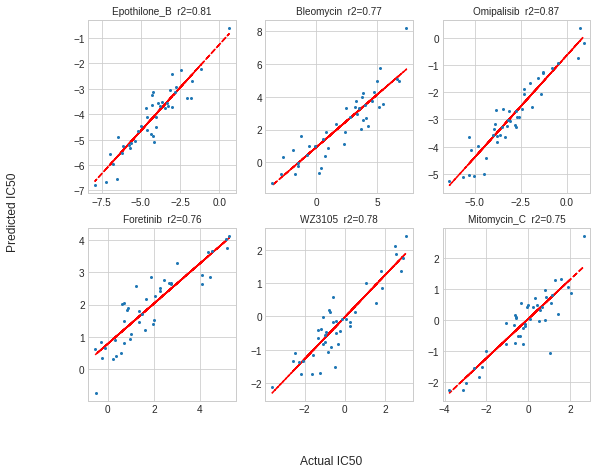

In [ ]:
X = DF1.iloc[:,43]
Y=DF2.iloc[:,43]
fig, ax = plt.subplots(2, 3, figsize=(9, 7))
z = np.polyfit(X, Y, 1)
p = np.poly1d(z)
ax[1, 0].plot(X,p(X),"r--")
ax[1, 0].plot(X, Y, 'o',markersize=2)
print(r2_score(X,Y))
titl="Foretinib"+"  r2="+str(round(r2_score(X,Y),2))
ax[1,0].set_title(titl, fontsize=10)
X = DF1.iloc[:,7]
Y=DF2.iloc[:,7]
z = np.polyfit(X, Y, 1)

p = np.poly1d(z)


ax[0, 0].plot(X,p(X),"r--")
ax[0, 0].plot(X, Y, 'o',markersize=2)
titl=DF1.columns[7]+"  r2="+str(round(r2_score(X,Y),2))
ax[0, 0].set_title(titl, fontsize=10)
X = DF1.iloc[:,14]
Y=DF2.iloc[:,14]
z = np.polyfit(X, Y, 1)
p = np.poly1d(z)
ax[1, 1].plot(X,p(X),"r--")
ax[1, 1].plot(X, Y, 'o',markersize=2)

titl=DF1.columns[14]+"  r2="+str(round(r2_score(X,Y),2))
ax[1, 1].set_title(titl, fontsize=10)
X = DF1.iloc[:,64]
Y=DF2.iloc[:,64]
z = np.polyfit(X, Y, 1)
p = np.poly1d(z)
ax[0, 1].plot(X,p(X),"r--")

ax[0, 1].plot(X, Y, 'o',markersize=2)

titl=DF1.columns[64]+"  r2="+str(round(r2_score(X,Y),2))
ax[0, 1].set_title(titl, fontsize=10)

X = DF1.iloc[:,10]
Y=DF2.iloc[:,10]

z = np.polyfit(X, Y, 1)
p = np.poly1d(z)
ax[0, 2].plot(X,p(X),"r--")
ax[0, 2].plot(X, Y, 'o',markersize=2)
titl=DF1.columns[10]+"  r2="+str(round(r2_score(X,Y),2))
ax[0, 2].set_title(titl, fontsize=10)
X = DF1.iloc[:,13]
Y=DF2.iloc[:,13]

z = np.polyfit(X, Y, 1)
p = np.poly1d(z)
ax[1, 2].plot(X,p(X),"r--")
ax[1, 2].plot(X, Y, 'o',markersize=2)
titl=DF1.columns[13]+"  r2="+str(round(r2_score(X,Y),2))
ax[1, 2].set_title(titl, fontsize=10)
ax[1,2].legend(loc='upper left')
fig.text( 0.5, 0.0,'Actual IC50', ha='center', fontsize=12)
fig.text(0.0, 0.5, 'Predicted IC50', va='center', rotation='vertical', fontsize=12)



In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from numpy import mean

In [ ]:
psonr=[]
mse=[]
for i in range(108):
#f=f1_score(y_real_scores,Y_pred_score)
  #print(DF2.iloc[:,i])
  pr=pearsonr(DF2.iloc[:,i].values,DF1.iloc[:,i].values)
  ms=mean_squared_error(DF1.iloc[:,i].values,DF2.iloc[:,i].values)
  #print(pr)
  #a=input("enter")
  #precision=precision_score(y_real_scores,Y_pred_score)
  #recall=recall_score(y_real_scores,Y_pred_score, y_pred_prob)
  psonr.append(pr[0])
  mse.append(ms)
print(round(mean(psonr),2),round(mean(mse),2))

0.81 0.63


In [ ]:
drug_resp = pd.DataFrame()
drug_resp['Drugs'] = drug_list
drug_resp['Pred_values'] = psonr
drug_resp['MSE'] = mse
#drug1.reset_index(drop=True,inplace=True)
#print(drug1)
print(drug_resp)

            Drugs  Pred_values       MSE
0       Tamoxifen     0.581868  0.565824
1      Dabrafenib     0.804766  1.067914
2       Veliparib     0.732653  0.190526
3    Lenalidomide     0.657501  0.253377
4         PLX4720     0.737359  0.578996
..            ...          ...       ...
103     Niraparib     0.644728  0.399660
104      Olaparib     0.699401  0.534837
105   Palbociclib     0.782404  0.579960
106    Ribociclib     0.697588  0.458063
107     Alpelisib     0.814408  1.045282

[108 rows x 3 columns]


In [ ]:
drug_resp.to_csv("pcc_29_Jan.csv")

In [ ]:
drugs=drug_resp.set_index('Drugs').T.to_dict('list')

In [ ]:
drugs.items()

dict_items([('Tamoxifen', [0.5818680283831438, 0.5658240855430811]), ('Dabrafenib', [0.8047663927835708, 1.0679142455686783]), ('Veliparib', [0.7326530620872241, 0.19052574323581087]), ('Lenalidomide', [0.6575005293379147, 0.25337746641014114]), ('PLX4720', [0.7373587959272523, 0.5789964853609856]), ('JNK_Inhibitor_VIII', [0.6991781558782303, 0.2515640412478089]), ('VX_11e', [0.8172174792995712, 0.678444602681269]), ('Epothilone_B', [0.9251361552893788, 0.5709925374687783]), ('PLX4720__rescreen_', [0.8382773071376687, 0.2718871970940532]), ('GSK1070916', [0.8110310070849304, 1.3733042681401968]), ('Omipalisib', [0.9476144399157543, 0.37416947540931494]), ('QL_X_138', [0.9100558187065343, 0.4540591554664514]), ('NU_7441', [0.7355171226823178, 0.3790832330973435]), ('Mitomycin_C', [0.8873680219743794, 0.5005319824744255]), ('WZ3105', [0.9091619346262262, 0.5584854967717776]), ('CP724714', [0.8844969306536876, 0.7276754394876902]), ('Quizartinib', [0.8021654419185807, 0.3089198798850664])

In [ ]:
def get_key(val):
    for key, value in drugs.items():
      #print("******%",value[0],key)
      if val == value[0]:
        #print("******%",key)
        return key

In [ ]:
def get_key_mse(val):
    for key, value in drugs.items():
      #print("******%",value[0],key)
      if val == value[1]:
        #print("******%",key)
        return key

In [ ]:
def make_labels(ax, boxplot):

    # Grab the relevant Line2D instances from the boxplot dictionary
    iqr = boxplot['boxes'][0]
    caps = boxplot['caps']
    med = boxplot['medians'][0]
    fly = boxplot['fliers'][0]

    # The x position of the median line
    xpos = med.get_xdata()

    # Lets make the text have a horizontal offset which is some 
    # fraction of the width of the box
    xoff = 0.1 * (xpos[1] - xpos[0])
   
    # The x position of the labels
    xlabel = xpos[1] + xoff

    # The median is the y-position of the median line
    median = med.get_ydata()[1]

    # The 25th and 75th percentiles are found from the
    # top and bottom (max and min) of the box
    pc25 = iqr.get_ydata().min()
    pc75 = iqr.get_ydata().max()

    # The caps give the vertical position of the ends of the whiskers
    capbottom = caps[0].get_ydata()[0]
    captop = caps[1].get_ydata()[0]

    # Make some labels on the figure using the values derived above
    
    ax.text(1.02, captop,
            get_key_mse(captop), va='bottom')
    ax.text(1.02, capbottom,
            get_key_mse(capbottom), va='bottom')
    # Many fliers, so we loop over them and create a label for each one
    #print(fly.get_ydata())
    i=1
    j=0.82
    for flier in fly.get_ydata():
     key=get_key_mse(flier)
     print(flier)
     ax.text(j+xoff,flier ,key,va='center')
     i=i+1
     if (i>6):
        j=1
    


In [ ]:
def make_labels1(ax, boxplot):

    # Grab the relevant Line2D instances from the boxplot dictionary
    iqr = boxplot['boxes'][0]
    caps = boxplot['caps']
    med = boxplot['medians'][0]
    fly = boxplot['fliers'][0]

    # The x position of the median line
    xpos = med.get_xdata()

    # Lets make the text have a horizontal offset which is some 
    # fraction of the width of the box
    xoff = 0.1 * (xpos[1] - xpos[0])
   
    # The x position of the labels
    xlabel = xpos[1] + xoff

    # The median is the y-position of the median line
    median = med.get_ydata()[1]

    # The 25th and 75th percentiles are found from the
    # top and bottom (max and min) of the box
    pc25 = iqr.get_ydata().min()
    pc75 = iqr.get_ydata().max()

    # The caps give the vertical position of the ends of the whiskers
    capbottom = caps[0].get_ydata()[0]
    captop = caps[1].get_ydata()[0]

    # Make some labels on the figure using the values derived above
    
    ax.text(1, captop,
            get_key(captop), va='bottom')
    ax.text(1, capbottom,
            get_key(capbottom), va='bottom')
    # Many fliers, so we loop over them and create a label for each one
    #print(fly.get_ydata())
    j=0.85
    i=1
    for flier in fly.get_ydata():
     key=get_key(flier)
     print(flier)
     ax.text(j+xoff,flier ,key,va='center')
     i=i+1
     if (i>3):
        j=1
    


0.5818680283831438
0.6084567873723523
0.6286295401148289
0.6310522144811939
0.6447282630027658


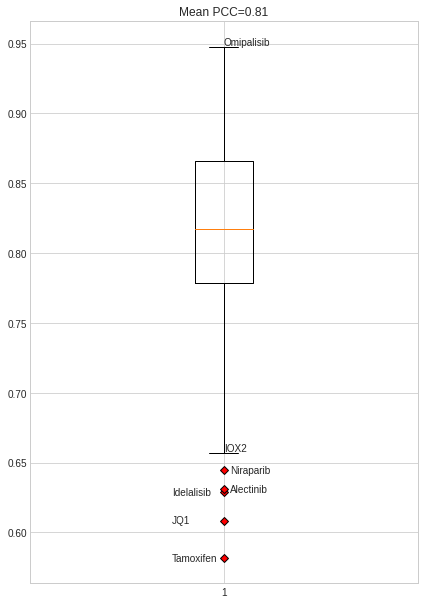

In [ ]:
# Make the figure
plt.rcParams["figure.figsize"] = [6,8.50]
plt.rcParams["figure.autolayout"] = True
red_diamond = dict(markerfacecolor='r', marker='D')
fig3, ax3 = plt.subplots()
#data={"Box1": drug_resp.iloc[:,1], "Box2": drug_resp.iloc[:,1]}
ax3.set_title('Mean PCC=0.81')
# Create the boxplot and store the resulting python dictionary
my_boxes = ax3.boxplot(drug_resp.iloc[:,1], flierprops=red_diamond)
# Call the function to make labels
make_labels1(ax3, my_boxes)

plt.show()


1.3733042681401968
1.5546472504655395
1.8698119237466366
1.6209988127079886
1.8244358959585927
1.4644584281485098
1.4445840953141713


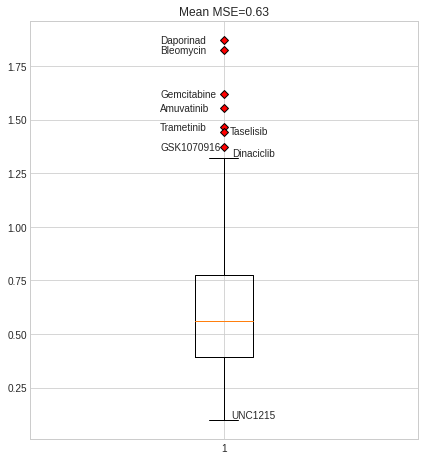

In [ ]:
plt.rcParams["figure.figsize"] = [6, 6.5]
plt.rcParams["figure.autolayout"] = True
red_diamond = dict(markerfacecolor='r', marker='D')
fig3, ax3 = plt.subplots()
ax3.set_title('Mean MSE=0.63')
# Create the boxplot and store the resulting python dictionary
my_boxes = ax3.boxplot(drug_resp.iloc[:,2], flierprops=red_diamond)
# Call the function to make labels
make_labels(ax3, my_boxes)
plt.show()

Classifcaation **results** **bold text**

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [ ]:

thre=pd.read_excel("/content/gdrive/MyDrive/multiomics/drug_DeepMO/thres_DR_108-screened_drugs_imputed-new.xlsx")
#DF_pred=pd.read_csv('/content/pred_multi_Reg_full_rms_17_Jan.csv',index_col=0,header=0)
#DF_real=pd.read_csv('/content/real_multi_Reg_full_rms_17_Jan.csv',index_col=0,header=0)

In [ ]:
thre

,Tamoxifen,Dabrafenib,Veliparib,Lenalidomide,PLX4720,JNK_Inhibitor_VIII,VX_11e,Epothilone_B,PLX4720__rescreen_,GSK1070916,Omipalisib,QL_X_138,NU_7441,Mitomycin_C,WZ3105,CP724714,Quizartinib,Tipifarnib,SNX_2112,PI_103,Dacinostat,JQ1,SGC0946,GSK429286A,AS605240,SB590885,Ispinesib Mesylate,TL_1_85,Ruxolitinib,OSI_027,AKT inhibitor VIII,I_BET,Midostaurin,Y_39983,HG_6_64_1,PIK_93,JW_7_24_1,MPS_1_IN_1,BX_795,STF_62247,...,Genentech_Cpd_10,BMS_345541,Masitinib,CCT007093,Nutlin_3a,Trametinib,VNLG_124,UNC1215,WHI-P97,Tivozanib,NSC_207895,JQ12,Temozolomide,Selisistat,X5_Fluorouracil,PHA_793887,KIN001_244,Luminespib,SB52334,Temsirolimus,ZSTK474,Dactolisib,Vinblastine,YM201636,YK_4_279,KIN001_266,GSK690693,Belinostat,Lestaurtinib,IOX2,FTI_277,Talazoparib,Taselisib,Dinaciclib,Lapatinib,Niraparib,Olaparib,Palbociclib,Ribociclib,Alpelisib
0,3.952998,4.55405,4.425265,4.208429,4.748535,4.879868,4.130198,-4.255736,4.790662,2.893132,-3.18262,1.461232,2.997847,-0.103221,-0.642884,4.248472,2.299508,1.760799,0.599725,0.867042,-3.06648,2.505019,2.025879,5.515819,3.295571,4.209391,-1.218306,4.253916,4.354766,1.424765,2.252268,3.870824,0.618688,5.1223,1.753363,2.807039,1.662973,5.031926,3.016555,4.947278,...,2.766802,3.474181,3.790163,4.237634,4.266152,0.912813,4.275937,2.793328,4.536353,0.694579,4.740051,1.359302,5.906698,5.599861,4.248291,3.02667,3.486936,-2.688651,4.407525,-1.813418,0.988524,-2.273881,-3.582804,2.363722,1.847877,3.317382,3.065921,0.599018,0.478885,0.284827,2.314745,4.348832,1.338017,-3.045637,2.176792,5.101153,4.545105,3.916276,3.738091,3.06905


# **Classification for predicted values**

In [ ]:
DF1.shape

(42, 108)

In [ ]:
thr=thre.values
df1=DF1.values
thr1=thr[0]
res=np.array(df1.T)
j=0
  
for x in res:
  #print(x)
  i=0
  for y in x:
   y =0 if df1[i][j] > thr1[j] else 1
   res[j][i]=y
   print(i)
   i=i+1
    
  print(j)
  j=j+1
  #print(j)
res1=res.T
DF3 = pd.DataFrame(res1)
#save the dataframe as a csv file
DF3.to_csv("pred_sens_jan_12.csv")

In [ ]:
drug_list

# **Classification for real values**

In [ ]:
thr=thre.values
df1=DF2.values
thr1=thr[0]
res=np.array(df1.T)
j=0
for x in res:
   #print(x)
   i=0
   for y in x:
    y =0 if df1[i][j] > thr1[j] else 1
    res[j][i]=y
    i=i+1
    
    #print(thr1[j])
   #inpu=input("get")
   j=j+1
  #print(j)

  #print(j)
res1=res.T
DF4 = pd.DataFrame(res1)
#save the dataframe as a csv file
DF4.to_csv("real_sens_jan_12.csv")

In [ ]:
DF3.columns=drug_list
DF4.columns=drug_list

In [ ]:
DF4.drop(DF4.columns[[0,21,48,49,76,71,72,54,97,103,3,80,87,89,100,101,106,5,12,40,81]], axis = 1, inplace = True)
DF3.drop(DF3.columns[[0,21,48,49,76,71,72,54,97,103,3,80,87,89,100,101,106,5,12,40,81]], axis = 1, inplace = True)


In [ ]:
from numpy.lib.function_base import append
acc=[]
overall_fpr=[]
overall_tpr=[]

for i in range(87):
#f=f1_score(y_real_scores,Y_pred_score)
  #print(DF2.iloc[:,i])
  a=accuracy_score(DF3.iloc[:,i].values,DF4.iloc[:,i].values)
  #print(a)
  fpr,tpr,_,= metrics.roc_curve(DF3.iloc[:,i].values,DF4.iloc[:,i].values)
  #precision=precision_score(y_real_scores,Y_pred_score)
  #recall=recall_score(y_real_scores,Y_pred_score, y_pred_prob)
  acc.append(a)
  overall_fpr.append(fpr[1])
  #print(fpr)
  overall_tpr.append(tpr[1])
print(round(mean(acc),2),round(mean(overall_tpr),2),round(mean(overall_fpr),2))


0.8 0.79 0.2


In [ ]:
DF4.shape

(42, 87)

In [ ]:
drug_acc = pd.DataFrame()
drug_acc['Drugs'] = DF4.columns
drug_acc['FPR'] = overall_fpr
drug_acc['Accuracy'] = acc
drug_acc['Sensitivity'] = overall_tpr
drug_acc["Specificity"]=1-drug_acc['FPR']
print(round(mean(drug_acc['Accuracy']),2))
#drug1.reset_index(drop=True,inplace=True)
print(drug_acc)


0.8


NameError: ignored

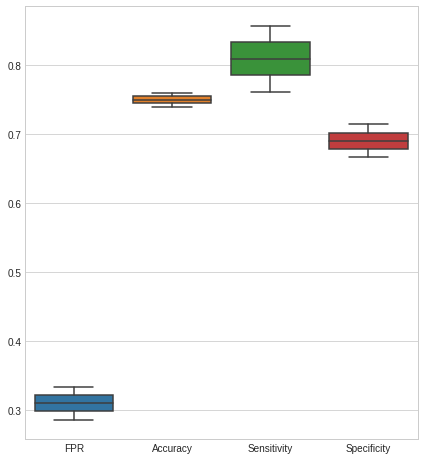

In [ ]:
import seaborn as sns
sns.boxplot( data=drug_acc[2:4])



plt.show()

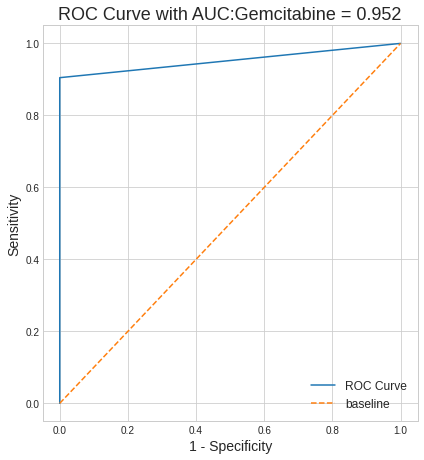

In [ ]:
a=accuracy_score(DF3['Gemcitabine'].values,DF4['Gemcitabine'].values)
  #print(a)
fpr,tpr,_,= metrics.roc_curve(DF3['Gemcitabine'].values,DF4['Gemcitabine'].values)
plt.plot(fpr, # False Positive Rate on X-axis
         tpr, # True Positive Rate on Y-axis
         label='ROC Curve')# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')# Label axes.
plt.title(f"ROC Curve with AUC:Gemcitabine = {round(metrics.roc_auc_score(DF3['Gemcitabine'].values,DF4['Gemcitabine'].values),3)}", fontsize=18)
plt.ylabel('Sensitivity', fontsize=14)
plt.xlabel('1 - Specificity', fontsize=14)# Create legend.
plt.legend(fontsize=12);

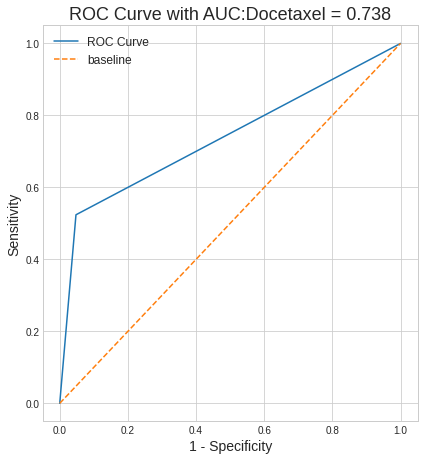

In [ ]:
a=accuracy_score(DF3['Docetaxel'].values,DF4['Docetaxel'].values)
  #print(a)
fpr,tpr,_,= metrics.roc_curve(DF3['Docetaxel'].values,DF4['Docetaxel'].values)
plt.plot(fpr, # False Positive Rate on X-axis
         tpr, # True Positive Rate on Y-axis
         label='ROC Curve')# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')# Label axes.
plt.title(f"ROC Curve with AUC:Docetaxel = {round(metrics.roc_auc_score(DF3['Docetaxel'].values,DF4['Docetaxel'].values),3)}", fontsize=18)
plt.ylabel('Sensitivity', fontsize=14)
plt.xlabel('1 - Specificity', fontsize=14)# Create legend.
plt.legend(fontsize=12);

In [ ]:
def get_key1(val):
    for key, value in drugs1.items():
      #print("******%",value[0],key)
      if val == value[2]:
        #print("******%",key)
        return key

In [ ]:
def make_labels(ax, boxplot):

    # Grab the relevant Line2D instances from the boxplot dictionary
    iqr = boxplot['boxes'][0]
    caps = boxplot['caps']
    med = boxplot['medians'][0]
    fly = boxplot['fliers'][0]

    # The x position of the median line
    xpos = med.get_xdata()

    # Lets make the text have a horizontal offset which is some 
    # fraction of the width of the box
    xoff = 0.10 * (xpos[1] - xpos[0])

    # The x position of the labels
    xlabel = xpos[1] + xoff

    # The median is the y-position of the median line
    median = med.get_ydata()[1]

    # The 25th and 75th percentiles are found from the
    # top and bottom (max and min) of the box
    pc25 = iqr.get_ydata().min()
    pc75 = iqr.get_ydata().max()

    # The caps give the vertical position of the ends of the whiskers
    capbottom = caps[0].get_ydata()[0]
    captop = caps[1].get_ydata()[0]

    # Make some labels on the figure using the values derived above
    
    ax.text(xlabel, captop,
            get_key1(captop), va='center')

    # Many fliers, so we loop over them and create a label for each one
   
    i=0
    for flier in fly.get_ydata():
     key=get_key(flier)
     ax.text(1 + xoff,flier ,key,
                 va='center')
     i=i+1      
     if (i>9):
        break
    


In [ ]:
drugs1=drug_acc.set_index('Drugs').T.to_dict('list')

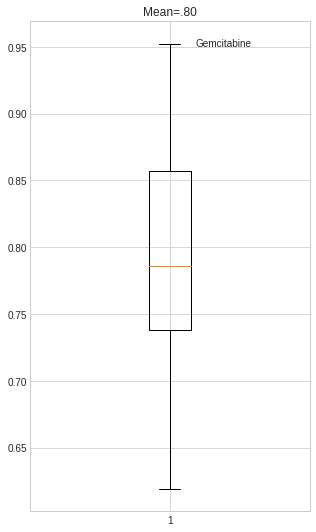

In [ ]:
plt.rcParams["figure.figsize"] = [4.50, 7.50]
plt.rcParams["figure.autolayout"] = True
red_diamond = dict(markerfacecolor='r', marker='D')
fig3, ax3 = plt.subplots()
#data={"Box1": drug_resp.iloc[:,1], "Box2": drug_resp.iloc[:,1]}
ax3.set_title('Mean=.80')
# Create the boxplot and store the resulting python dictionary
my_boxes = ax3.boxplot(drug_acc.iloc[:,1], flierprops=red_diamond)
# Call the function to make labels
make_labels(ax3, my_boxes)
plt.show()

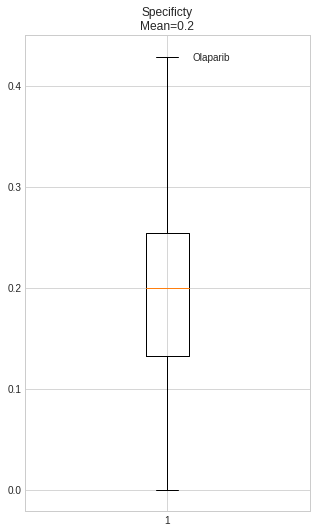

In [ ]:
plt.rcParams["figure.figsize"] = [4.50, 7.50]
plt.rcParams["figure.autolayout"] = True
red_diamond = dict(markerfacecolor='r', marker='D')
fig3, ax3 = plt.subplots()
#data={"Box1": drug_resp.iloc[:,1], "Box2": drug_resp.iloc[:,1]}
ax3.set_title('Specificty\nMean=0.2')
# Create the boxplot and store the resulting python dictionary
my_boxes = ax3.boxplot(drug_acc.iloc[:,2], flierprops=red_diamond)
# Call the function to make labels
make_labels(ax3, my_boxes)
plt.show()

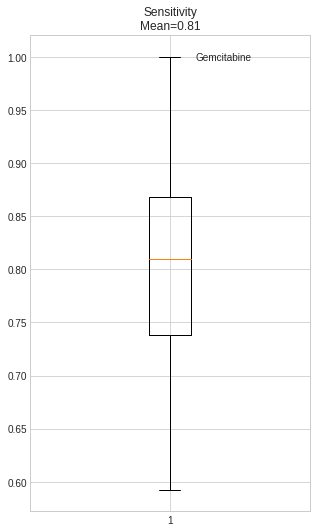

In [ ]:
plt.rcParams["figure.figsize"] = [4.50, 7.50]
plt.rcParams["figure.autolayout"] = True
red_diamond = dict(markerfacecolor='r', marker='D')
fig3, ax3 = plt.subplots()
#data={"Box1": drug_resp.iloc[:,1], "Box2": drug_resp.iloc[:,1]}
ax3.set_title('Sensitivity\nMean=0.81')
# Create the boxplot and store the resulting python dictionary
my_boxes = ax3.boxplot(drug_acc.iloc[:,3], flierprops=red_diamond)
# Call the function to make labels
make_labels(ax3, my_boxes)
plt.show()

In [ ]:
count_sen

,Drug,Pred,Real
0,1,41,40
1,2,42,42
2,3,40,37
3,4,41,38
4,5,42,42
...,...,...,...
103,104,42,42
104,105,42,42
105,106,20,22
106,107,24,25


In [ ]:
count_sen_cellines

NameError: ignored

Text(0.5, 1.0, 'Cancer Drug Effectiveness')

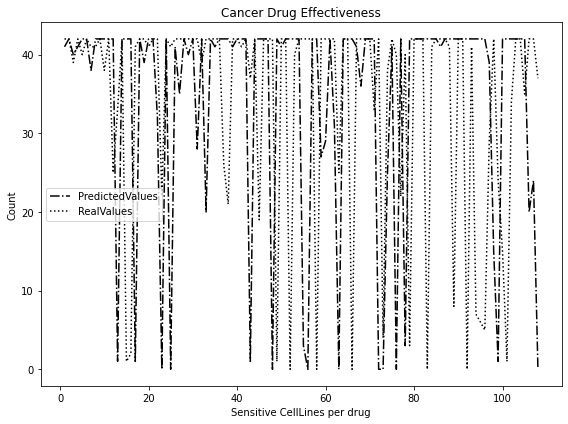

In [ ]:
count_sen=pd.read_csv('/content/count_sens.csv')
count_sen1 = count_sen.sample(frac = 1)
Drugs = count_sen.iloc[:,0]
value1 = count_sen.iloc[:,1]
value2=count_sen1.iloc[:,2]
y=[value1,value2]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(Drugs,value1,color="black",label="PredictedValues",linestyle="-.");
ax.plot(Drugs,value2,color="black",label="RealValues",linestyle=":");
ax.legend()
plt.xlabel('Sensitive CellLines per drug') 
plt.ylabel('Count') 
  
# displaying the title
plt.title("Cancer Drug Effectiveness")

Text(0.5, 1.0, 'Cell Line Sensitivity')

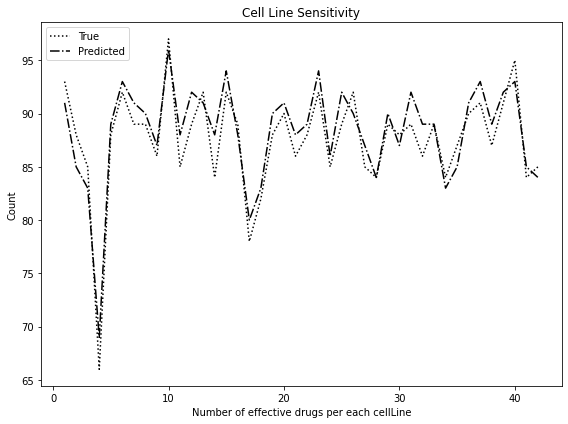

In [ ]:
count_sen=pd.read_excel('/content/count_sen_cellines.xlsx')
Drugs = count_sen.iloc[:,0]
value1 = count_sen.iloc[:,1]
value2=count_sen.iloc[:,2]
y=[value1,value2]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(Drugs,value1,color="black",linestyle=":",label="True");
ax.plot(Drugs,value2,color="black",linestyle="-.",label="Predicted");
ax.legend()
plt.xlabel('Number of effective drugs per each cellLine') 
plt.ylabel('Count') 
  
# displaying the title
plt.title("Cell Line Sensitivity")